In [10]:
import numpy as np
import math as m
from matplotlib import pyplot as plt
import random as r
from  matplotlib.animation import FuncAnimation
import sys
import stats
import pickle
from scipy import interpolate

In [11]:
## Takes array of data and returns it window averaged
def rolling_avg(arr, window):
    to_return = []
    for i in range(len(arr)):
        lower = int(i-window/2)
        upper = int(i+window/2)
        if lower < 0: lower = 0
        if upper >= len(arr): upper = len(arr)-1
        to_return.append(sum(arr[lower:upper])/(upper-lower))          
    return to_return

In [12]:
class Metropolis():
    
    def __init__(self, L, T=1, initial_state=0, B=False):
        if type(initial_state)==int:
            self.grid = np.ones(shape=[L, L])
            for i in range(L):
                self.grid[i] = np.random.choice([-1, 1], size=L)
        else:
            self.grid = initial_state
        self.L = L
        self.T = T
        self.B = 1/T
        if B:
            self.T = self.B
            self.B = T
        self.N = L*L
        self.energy = self.calc_energy()
        self.energy_history = [self.energy]
        self.grid_history = [np.copy(self.grid)]
        self.M_history = [np.sum(self.grid)]
        
        # This is for a L x L lattice
        x,y=np.indices((L,L))
        red=np.logical_and((x+y) % 2==0   , np.logical_and(x<L-1,y<L-1))
        red[L-1,L-1]=True
        blue=np.logical_and((x+y) % 2==1   , np.logical_and(x<L-1,y<L-1))
        green=np.logical_and((x+y) % 2==0   , np.logical_or(x==L-1,y==L-1))
        green[L-1,L-1]=False
        yellow=np.logical_and((x+y) % 2==1   , np.logical_or(x==L-1,y==L-1))
        self.red = red
        self.blue = blue
        self.green = green
        self.yellow = yellow
        self.colors = [red, blue, green, yellow]
        return
    
    def P(self, E):
        try:
            return m.exp(-self.B*E)
        except:
            print(f"E = {-self.B*E}")
            raise Exception("E too big for m.exp()")
    
    def run(self, sweeps, to_print=False):
        for sweep in range(sweeps):
            for color in self.colors:
                delta_Es = self.find_delta_Es(color)
                to_flip = np.random.random(size=delta_Es.shape) < 1/(1+np.exp(self.B*delta_Es))
                self.grid[color] = [-spin if flip else spin for spin, flip in zip(self.grid[color], to_flip)]
                self.energy += np.sum(delta_Es*to_flip)
            self.energy_history.append(self.energy)
            self.M_history.append(np.sum(self.grid))
            self.grid_history.append(np.copy(self.grid))
        return self.grid
    
    def find_delta_Es(self, color):
        orig = self.grid[color]
        delta_Es = np.zeros(shape=self.grid[color].shape)
        delta_Es += 2*orig * np.roll(self.grid, 1, axis=0)[color]
        delta_Es += 2*orig * np.roll(self.grid, -1, axis=0)[color]
        delta_Es += 2*orig * np.roll(self.grid, 1, axis=1)[color]
        delta_Es += 2*orig * np.roll(self.grid, -1, axis=1)[color]
        return delta_Es
    
    def flip_point(self, pt):
        delta_e = self.grid[pt]
        
    def left(self, point):
        if point[1] == 0:
            return [point[0], self.L-1]
        return [point[0], point[1]-1]
    
    def right(self, point):
        if point[1] == self.L-1:
            return [point[0], 0]
        return [point[0], point[1]+1]
    
    def up(self, point):
        if point[0] == 0:
            return [self.L-1, point[1]]
        return [point[0]-1, point[1]]
    
    def down(self, point):
        if point[0] == self.L-1:
            return [0, point[1]]
        return [point[0]+1, point[1]]
    
    def calc_energy(self, grid=0):
        if type(grid) == int: grid = self.grid
        energy = 0
        for y in range(self.L):
            for x in range(self.L):
                energy += grid[y, x] * self.E_up((y, x))
        return int(energy)
    
    def E_up(self, pt, grid=0, point=False):
        if type(grid) == int: grid = self.grid
        e = 0
        e += -grid[self.up(pt)[0], self.up(pt)[1]]
        e += -grid[self.left(pt)[0], self.left(pt)[1]]
        if point:
            e += -grid[self.down(pt)[0], self.down(pt)[1]]
            e += -grid[self.right(pt)[0], self.right(pt)[1]]
        return e
    
    def get_grid(self):
        return self.grid
    
    def get_energy_history(self):
        return self.energy_history
    
    def get_grid_history(self):
        return self.grid_history
    
    def get_M_history(self):
        return self.M_history

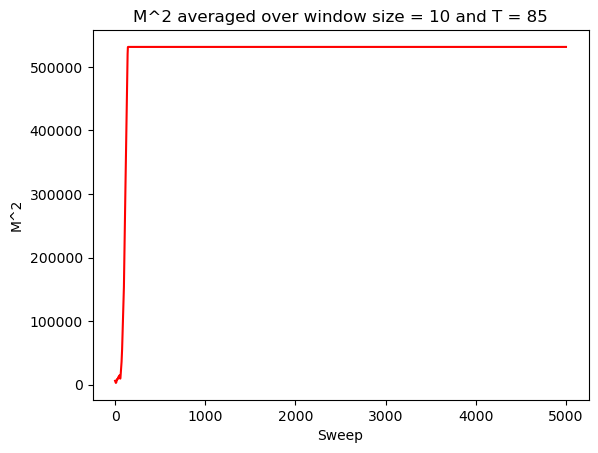

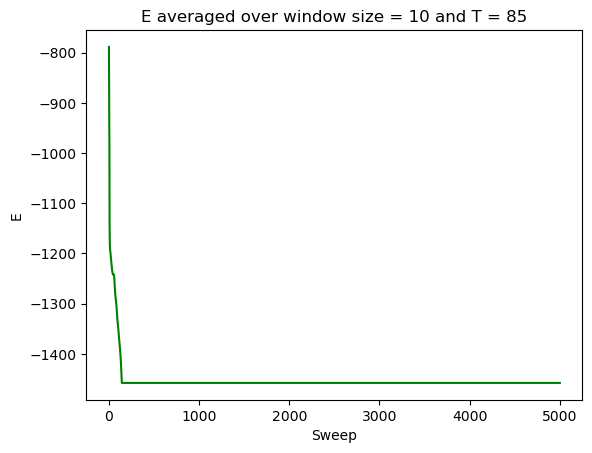

In [13]:
T = 85
testing = Metropolis(27, T, B=True)
testing.run(5000)
window = 10

plt.figure()
plt.plot(rolling_avg([M**2 for M in testing.get_M_history()], window), color='r')
plt.title(f"M^2 averaged over window size = {window} and T = {T}")
plt.xlabel("Sweep")
plt.ylabel("M^2")
plt.show()

plt.figure()
plt.plot(rolling_avg(testing.get_energy_history(), window), color='g')
plt.title(f"E averaged over window size = {window} and T = {T}")
plt.xlabel("Sweep")
plt.ylabel("E")
plt.show()

In [14]:
def grid_to_num(grid):
    shape = grid.shape
    num = ""
    for y in range(shape[0]):
        for x in range(shape[1]):
            if grid[y, x] == -1:
                num += "0"
                continue
            num += "1"
    return num

def num_to_grid(num):
    size = int(m.sqrt(len(num)))
    grid = np.ones([size, size])
    for i in range(len(num)):
        x = int(i % size)
        y = int(m.floor(i/size))
        grid[y, x] = 2*int(num[i])*grid[y, x]-1
    return grid

In [15]:
grid = num_to_grid('100010000')
print(grid)
plt.show()
print(grid_to_num(grid))

[[ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1. -1.]]
100010000


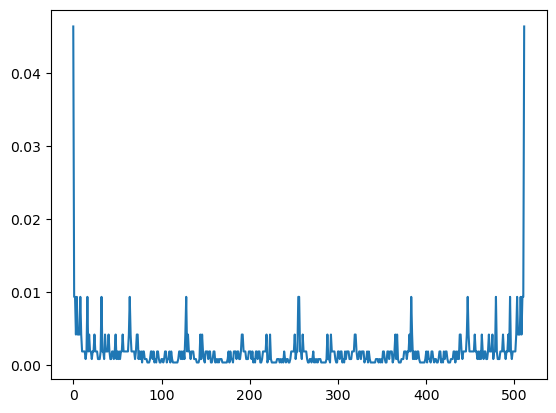

In [16]:
def theory_curve(B=0.5):
    ind = np.indices([2**9])[0]
    Energies = [-B*Metropolis(L=3, T=B, initial_state=num_to_grid(bin(i)[2:].zfill(9)), B=True).calc_energy() for i in ind]
    Probabilities = np.exp(Energies)
    Probabilities = [P/np.sum(Probabilities) for P in Probabilities]
    return ind, Probabilities
ind, probs = theory_curve(0.2)
plt.plot(ind, probs)
plt.show()

In [17]:
B = 0.3
metro = Metropolis(3, B, B=True)
metro.run(10000)
state_history = [int(grid_to_num(grid), 2) for grid in metro.get_grid_history()]

In [ ]:
weights = np.ones_like(state_history) / len(state_history)
plt.hist(state_history, bins=2**9, weights=weights, histtype='step', label="Simulator Results")
ind, probs = theory_curve(B)
plt.plot(ind, probs, color="r", linewidth=0.5, label="Theory Curve")
plt.title(f"Theory Curve vs. Simulator Results With " + r"$\beta$" + f" = {B}")
plt.xlabel("State")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [25]:
## Theory B=0
Ms = []
Es = []
L= 27
dummy = Metropolis(L, 1)
for i in range(100000):
    grid = np.ones(shape=[L, L])
    for i in range(L):
        grid[i] = np.random.choice([-1, 1], size=L)
    Ms.append(np.sum(grid)**2)
    Es.append(dummy.calc_energy(grid=grid))

In [57]:
## Theory CG B=0
Ms_CG = []
L= 81
for i in range(10000):
    grid = np.ones(shape=[L, L])
    for i in range(L):
        grid[i] = np.random.choice([-1, 1], size=L)
    Ms_CG.append(np.sum(coarse_grain(grid))**2)

In [58]:
print(stats.mean(Ms_CG))

723.1704


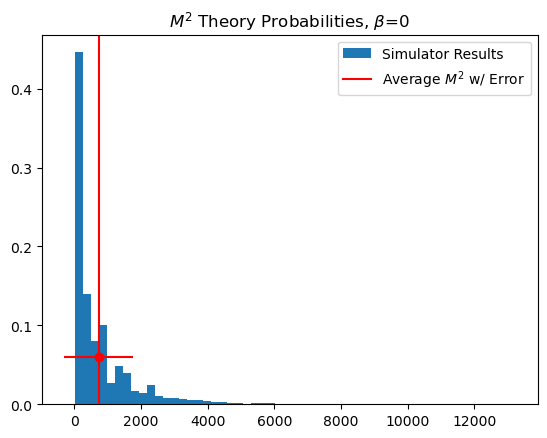

In [26]:
mean_M = stats.mean(Ms)
error_M = stats.stdev(Ms)
weights_M = np.ones_like(Ms) / len(Ms)
unique, counts = np.unique(Ms, return_counts=True)
plt.figure()
plt.title(r"$M^2$"+f" Theory Probabilities, " + r"$\beta$"+f"={0}")
plt.hist(Ms, bins=len(unique), weights=weights_M, histtype='bar', label="Simulator Results")
plt.axvline(mean_M, color="r", label=r"Average $M^2$ w/ Error")
plt.errorbar(mean_M, max(counts)/sum(counts), xerr=error_M,yerr=0,fmt="-or", ecolor='r')
plt.legend()
plt.show()

In [28]:
print(mean_M)

728.4884


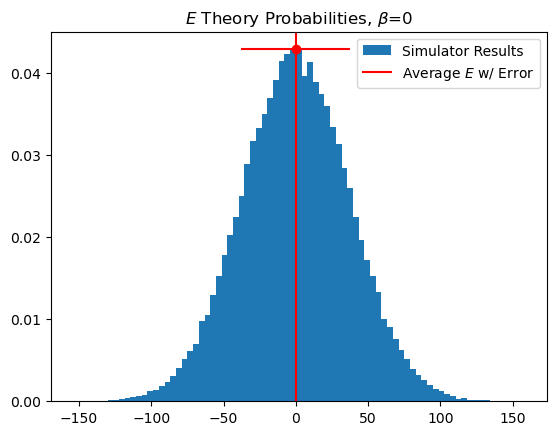

In [27]:
unique, counts = np.unique(Es, return_counts=True)
weights_E = np.ones_like(Es) / len(Es)
(mean_E, variance_E, error_E) = stats.mean(Es), stats.variance(Es), stats.stdev(Es)
plt.figure()
plt.title(r"$E$"+f" Theory Probabilities, " + r"$\beta$"+f"=0")
plt.hist(Es, bins=len(unique), weights=weights_E, histtype='bar', label="Simulator Results")
plt.axvline(mean_E, color="r", label=r"Average $E$ w/ Error")
plt.errorbar(mean_E, max(counts)/sum(counts), xerr=error_E,yerr=0,fmt="-or", ecolor='r')
plt.legend()
plt.show()

In [29]:
print(mean_E)

-0.00108


In [30]:
def page2_plots(B, runs=10000):
    model = Metropolis(27, B, B=True)
    model.run(runs)
    Es = model.get_energy_history()
    Ms = [M**2 for M in model.get_M_history()]
    weights_E = np.ones_like(Es) / len(Es)
    weights_M = np.ones_like(Ms) / len(Ms)
    (mean_E, variance_E, error_E) = stats.mean(Es), stats.variance(Es), stats.stdev(Es)
    (mean_M, variance_M, error_M) = stats.mean(Ms), stats.variance(Ms), stats.stdev(Ms)
    plt.figure()
    plt.matshow(model.get_grid())
    plt.title(f"Grid after {runs} runs, " + r"$\beta$"+f"={B}")
    plt.show()
    
    unique, counts = np.unique(Es, return_counts=True)
    plt.figure()
    plt.title(r"$E$"+f" Probabilities, " + r"$\beta$"+f"={B}")
    plt.hist(Es, bins=len(unique), weights=weights_E, histtype='bar', label="Simulator Results")
    plt.axvline(mean_E, color="r", label=r"Average $E$ w/ Error")
    plt.errorbar(mean_E, max(counts)/sum(counts), xerr=error_E,yerr=0,fmt="-or", ecolor='r')
    plt.legend()
    plt.show()
    
    unique, counts = np.unique(Ms, return_counts=True)
    plt.figure()
    plt.title(r"$M^2$"+f" Probabilities, " + r"$\beta$"+f"={B}")
    plt.hist(Ms, bins=len(unique), weights=weights_M, histtype='bar', label="Simulator Results")
    plt.axvline(mean_M, color="r", label=r"Average $M^2$ w/ Error")
    plt.errorbar(mean_M, max(counts)/sum(counts), xerr=error_M,yerr=0,fmt="-or", ecolor='r')
    plt.legend()
    plt.show()

In [31]:
def M_Squared_vs_B(Bs, runs=10000, offset=1000, L=27, CG=0, print_grid=False):
    M_avgs = []
    M_errors = []
    try:
        num_Bs = len(Bs)
    except:
        num_Bs = 1
    for i in range(num_Bs):
        sys.stdout.write('\r')
        per = (i + 1) / num_Bs
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*per), 100*per))
        sys.stdout.flush()
        if num_Bs == 1:
            this_B = Bs
        else:
            this_B = Bs[i]
        model = Metropolis(L, T=this_B, B=True)
        fin_grid = model.run(runs)
        if print_grid:
            plt.figure()
            plt.matshow(fin_grid, cmap='gray', vmin=-1, vmax=1)
            plt.show()
        if CG == 0:
            Ms = [M**2 for M in model.get_M_history()[offset:]]
        else:
            Ms = [np.sum(coarse_grain(grid, CG))**2 for grid in model.get_grid_history()[offset:]]
        M_avgs.append(stats.mean(Ms))
        M_errors.append(stats.stdev(Ms))
    return M_avgs, M_errors

In [18]:
Bs = [0.0001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
# M_avgs, M_errors = M_Squared_vs_B(Bs, runs=15000, offset=5000)

In [32]:
# M_square_data = [[B, Ma, Me] for B, Ma, Me in zip(Bs, M_avgs, M_errors)]
# with open("M_square_data.pkl", "wb") as fp:   #Pickling
#     pickle.dump(M_square_data, fp)

with open("M_square_data.pkl", "rb") as fp:   # Unpickling
    M_square_data = pickle.load(fp)

Bs = [o[0] for o in M_square_data]
M_avgs = [o[1] for o in M_square_data]
M_errors = [o[2] for o in M_square_data]

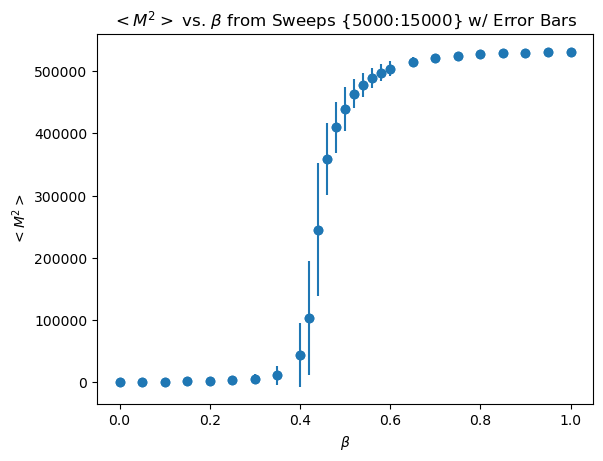

In [33]:
plt.figure()
plt.scatter(Bs, M_avgs)
plt.errorbar(Bs, M_avgs, yerr=M_errors, fmt="o")
plt.title(r"$<M^2>$ vs. $\beta$ from Sweeps {5000:15000} w/ Error Bars")
plt.ylabel(r"$<M^2>$")
plt.xlabel(r"$\beta$")
plt.show()

In [34]:
def E_vs_T(Ts, runs=10000, offset=1000):
    E_avgs = []
    E_errors = []
    for i in range(len(Ts)):
        sys.stdout.write('\r')
        per = (i + 1) / len(Ts)
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*per), 100*per))
        sys.stdout.flush()
        model = Metropolis(27, T=Ts[i])
        model.run(runs)
        Es = model.get_energy_history()[offset:]
        E_avgs.append(stats.mean(Es))
        E_errors.append(stats.stdev(Es))
    return E_avgs, E_errors

In [35]:
# Ts = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
# E_avgs, E_errors = E_vs_T(Ts, runs=15000, offset=5000)

In [36]:
# E_square_data = [[T, Ea, Ee] for T, Ea, Ee in zip(Ts, E_avgs, E_errors)]
# with open("E_square_data.pkl", "wb") as fp:   #Pickling
#     pickle.dump(E_square_data, fp)

with open("E_square_data.pkl", "rb") as fp:   # Unpickling
    E_square_data = pickle.load(fp)

Ts = [o[0] for o in E_square_data]
E_avgs = [o[1] for o in E_square_data]
E_errors = [o[2] for o in E_square_data]

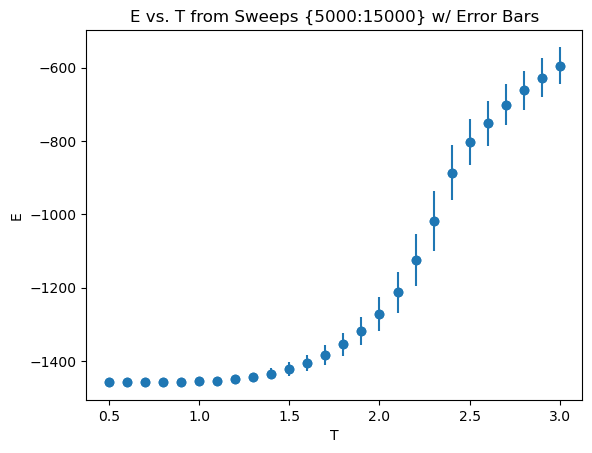

In [37]:
plt.figure()
plt.scatter(Ts, E_avgs)
plt.errorbar(Ts, E_avgs, yerr=E_errors, fmt="o")
plt.title("E vs. T from Sweeps {5000:15000} w/ Error Bars")
plt.ylabel("E")
plt.xlabel("T")
plt.show()

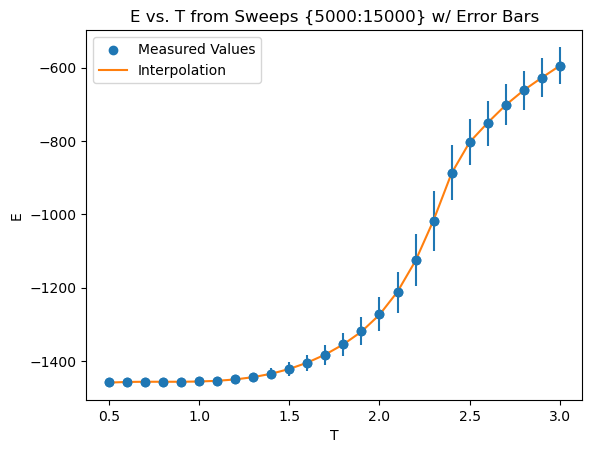

In [38]:
spl = interpolate.UnivariateSpline(Ts, E_avgs)
plt.figure()
plt.scatter(Ts, E_avgs, label="Measured Values")
plt.errorbar(Ts, E_avgs, yerr=E_errors, fmt="o")
plt.plot(Ts, spl(Ts), label="Interpolation")
plt.title("E vs. T from Sweeps {5000:15000} w/ Error Bars")
plt.ylabel("E")
plt.xlabel("T")
plt.legend()
plt.show()

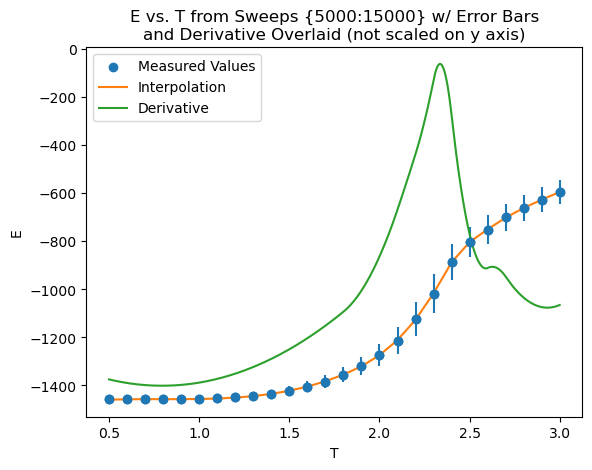

In [39]:
spl = interpolate.UnivariateSpline(Ts, E_avgs)
plt.figure()
plt.scatter(Ts, E_avgs, label="Measured Values")
plt.errorbar(Ts, E_avgs, yerr=E_errors, fmt="o")
plt.plot(Ts, spl(Ts), label="Interpolation")
plt.plot(np.arange(0.5, 3, 0.001), spl.derivative()(np.arange(0.5, 3, 0.001))-1400, label="Derivative")
plt.title("E vs. T from Sweeps {5000:15000} w/ Error Bars\nand Derivative Overlaid (not scaled on y axis)")
plt.ylabel("E")
plt.xlabel("T")
plt.legend()
plt.show()

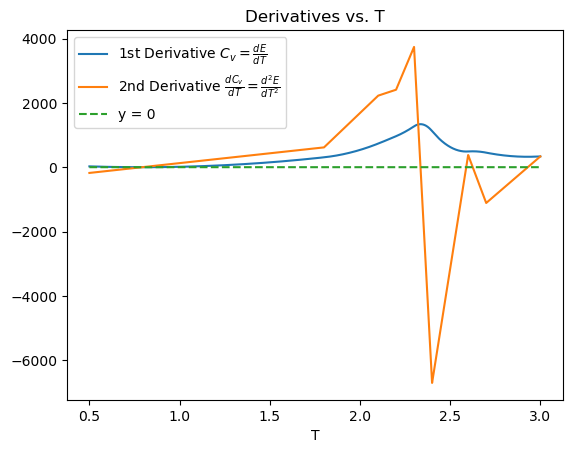

In [40]:
spl = interpolate.UnivariateSpline(Ts, E_avgs)
plt.figure()
plt.plot(np.arange(0.5, 3, 0.00001), spl.derivative(1)(np.arange(0.5, 3, 0.00001)), label=r"1st Derivative $C_v = \frac{dE}{dT}$")
plt.plot(np.arange(0.5, 3, 0.00001), spl.derivative(2)(np.arange(0.5, 3, 0.00001)), label=r"2nd Derivative $\frac{dC_v}{dT} = \frac{d^2E}{dT^2}$")
plt.plot(np.arange(0.5, 3, 0.00001), np.arange(0.5, 3, 0.00001)*0, label='y = 0', linestyle='dashed')
plt.title(r"Derivatives vs. T")
plt.xlabel("T")
plt.legend()
plt.show()

Transition Point is T = 2.3357921600341793, B = 0.4281202827503998


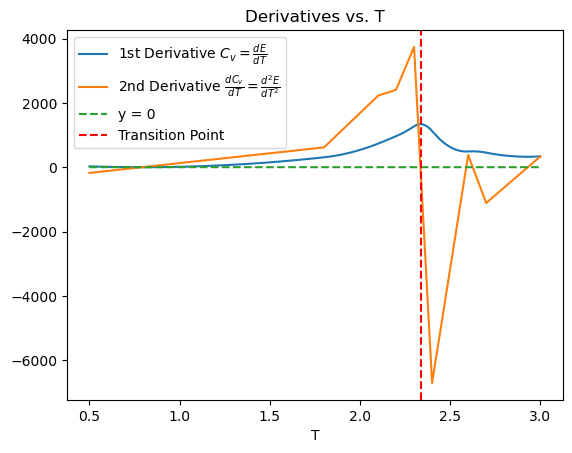

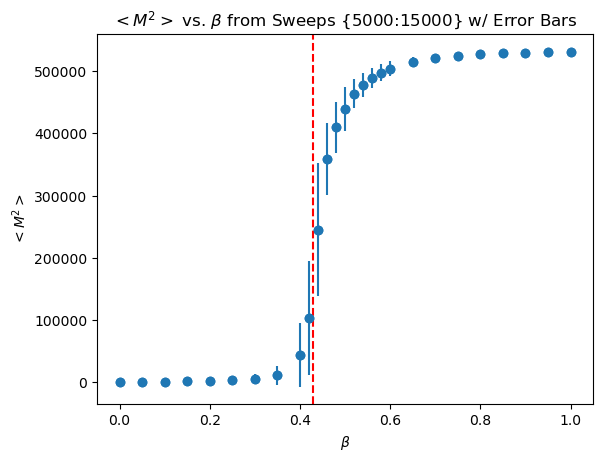

In [41]:
delta = 0.1
val=2.3
while delta > .0000001:
    if spl.derivative(2)(val) > 0:
        val += delta
        if spl.derivative(2)(val) < 0:
            delta = delta/2
    elif spl.derivative(2)(val) < 0:
        val += -delta
        if spl.derivative(2)(val) > 0:
            delta = delta/2
print(f"Transition Point is T = {val}, "+r"B"+f" = {1/val}")
spl = interpolate.UnivariateSpline(Ts, E_avgs)
plt.figure()
plt.plot(np.arange(0.5, 3, 0.00001), spl.derivative(1)(np.arange(0.5, 3, 0.00001)), label=r"1st Derivative $C_v = \frac{dE}{dT}$")
plt.plot(np.arange(0.5, 3, 0.00001), spl.derivative(2)(np.arange(0.5, 3, 0.00001)), label=r"2nd Derivative $\frac{dC_v}{dT} = \frac{d^2E}{dT^2}$")
plt.plot(np.arange(0.5, 3, 0.00001), np.arange(0.5, 3, 0.00001)*0, label='y = 0', linestyle='dashed')
plt.axvline(val, label="Transition Point", color='r', linestyle='dashed')
plt.title(r"Derivatives vs. T")
plt.xlabel("T")
plt.legend()
plt.show()

plt.figure()
plt.scatter(Bs, M_avgs)
plt.errorbar(Bs, M_avgs, yerr=M_errors, fmt="o")
plt.axvline(1/val, label="Transition Point", color='r', linestyle='dashed')
plt.title(r"$<M^2>$ vs. $\beta$ from Sweeps {5000:15000} w/ Error Bars")
plt.ylabel(r"$<M^2>$")
plt.xlabel(r"$\beta$")
plt.show()

In [29]:
Bs_new = [0.00001, 0.3, 0.4, 0.5, 0.6, 50]
grids = [Metropolis(81, B, B=True).run(15000) for B in Bs_new]

KeyboardInterrupt: 

In [42]:
# Example_coarse_grids = [[B, grid] for B, grid in zip(Bs_new, grids)]
# with open("Example_coarse_grids.pkl", "wb") as fp:   #Pickling
#     pickle.dump(Example_coarse_grids, fp)

with open("Example_coarse_grids.pkl", "rb") as fp:   # Unpickling
    Example_coarse_grids = pickle.load(fp)

Bs_new = [o[0] for o in Example_coarse_grids]
grids = [o[1] for o in Example_coarse_grids]

<Figure size 640x480 with 0 Axes>

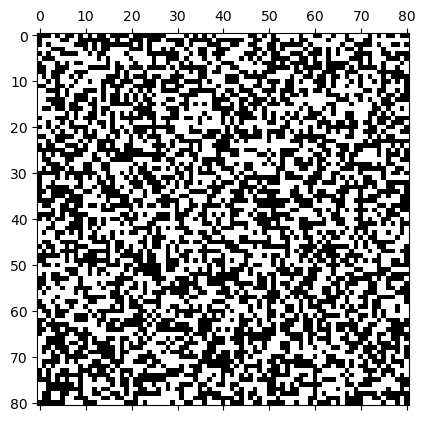

<Figure size 640x480 with 0 Axes>

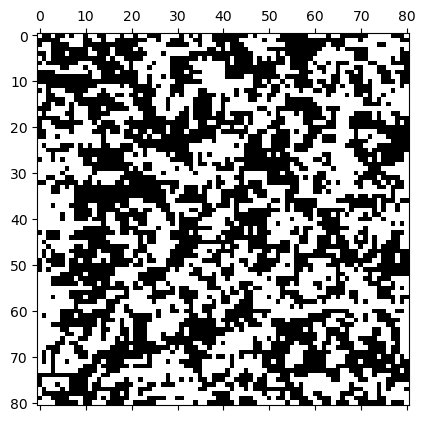

<Figure size 640x480 with 0 Axes>

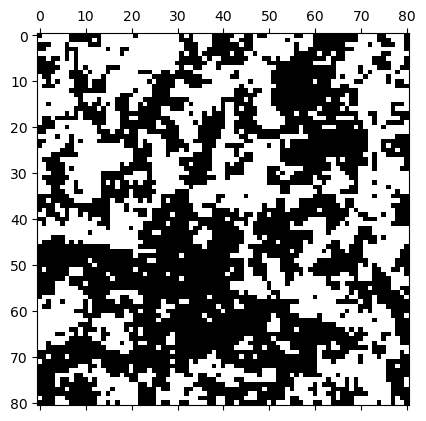

<Figure size 640x480 with 0 Axes>

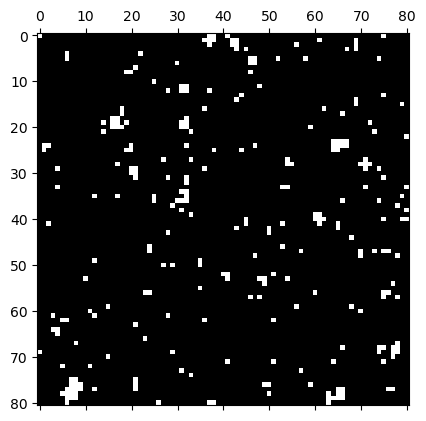

<Figure size 640x480 with 0 Axes>

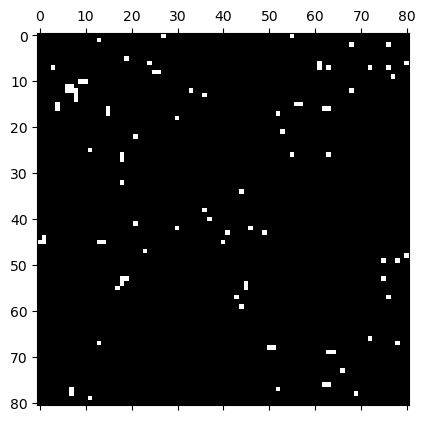

<Figure size 640x480 with 0 Axes>

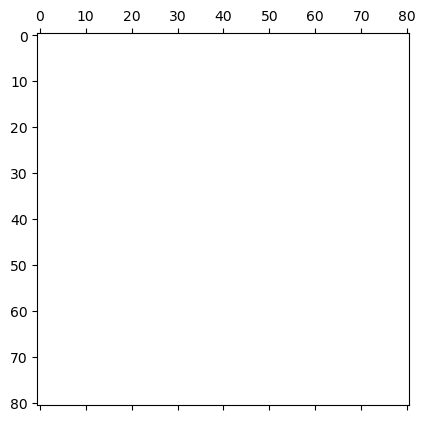

In [43]:
for grid in grids:
    plt.figure()
    plt.matshow(grid, cmap='gray', vmin=-1, vmax=1)
    plt.show()

In [51]:
def coarse_grain(grid, num=1):
    if num==0: return grid
    L = grid.shape[0]
    n = int(L/3)
    to_return = np.ones((n, n))
    for y in range(n):
        for x in range(n):
            if np.mean(grid[y*3:(y+1)*3, x*3:(x+1)*3]) < 0: to_return[y, x] = -1
    return coarse_grain(to_return, num-1)

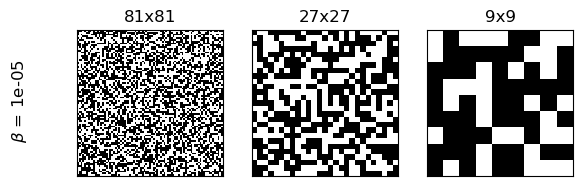

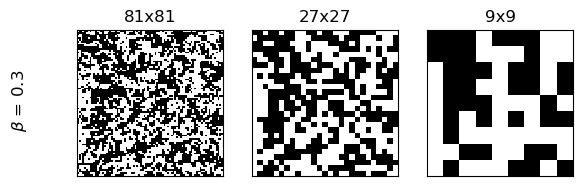

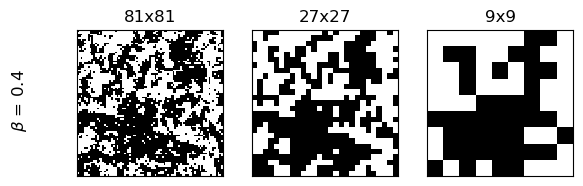

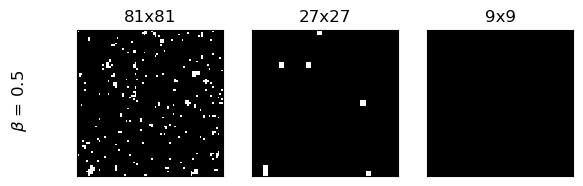

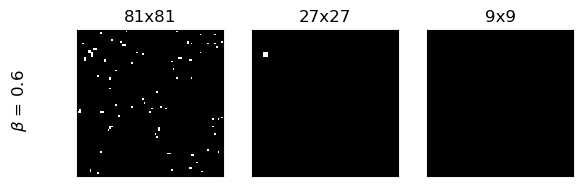

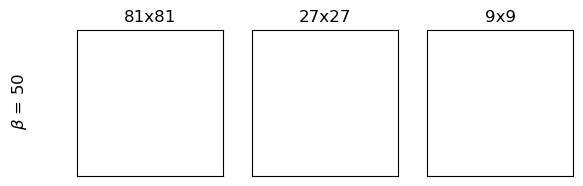

In [45]:
for i in range(len(grids)):
    grid = grids[i]
    B = Bs_new[i]
    fig, axs = plt.subplots(1, 3)
#     fig.suptitle(r"Grids for $\beta$ = "+f"{B} at Different Resolutions")
    fig.supylabel(r"$\beta$ = "+f"{B}")
    axs[0].matshow(grid, cmap='gray', vmin=-1, vmax=1)
    axs[0].set_title("81x81")
    axs[0].tick_params(top=False, labeltop=False, left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    axs[1].matshow(coarse_grain(grid), cmap='gray', vmin=-1, vmax=1)
    axs[1].set_title("27x27")
    axs[1].tick_params(top=False, labeltop=False, left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    axs[2].matshow(coarse_grain(grid, 2), cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title("9x9")
    axs[2].tick_params(top=False, labeltop=False, left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    plt.show()

In [214]:
## We already have native 27x27 from above
# Bs = [0.0001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
# # M_avgs, M_errors = M_Squared_vs_B(Bs, runs=15000, offset=5000)
# M_coarse_avgs, M_coarse_errors = M_Squared_vs_B(Bs, runs=15000, offset=5000, L=81, CG=1)

[====================] 100%

In [25]:
# M_coarse_data = [[B, Mca, Mce] for B, Mca, Mce in zip(Bs, M_coarse_avgs, M_coarse_errors)]
# with open("M_coarse_data.pkl", "wb") as fp:   #Pickling
#     pickle.dump(M_coarse_data, fp)

with open("M_coarse_data.pkl", "rb") as fp:   # Unpickling
    M_coarse_data = pickle.load(fp)

Bs = [o[0] for o in M_coarse_data]
M_coarse_avgs = [o[1] for o in M_coarse_data]
M_coarse_errors = [o[2] for o in M_coarse_data]

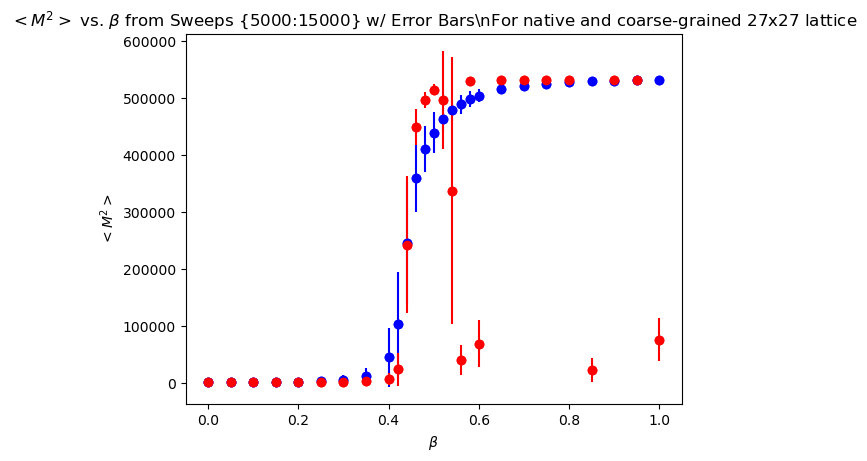

In [26]:
plt.figure()
plt.scatter(Bs, M_avgs, color='b', label='Native 27x27')
plt.errorbar(Bs, M_avgs, yerr=M_errors, fmt="o", color='b')
plt.scatter(Bs, M_coarse_avgs, color='r', label='Coarse-grained 27x27')
plt.errorbar(Bs, M_coarse_avgs, yerr=M_coarse_errors, fmt="o", color='r')
plt.title(r"$<M^2>$ vs. $\beta$ from Sweeps {5000:15000} w/ Error Bars\nFor native and coarse-grained 27x27 lattice")
plt.ylabel(r"$<M^2>$")
plt.xlabel(r"$\beta$")
plt.show()

[====================] 100%

<Figure size 640x480 with 0 Axes>

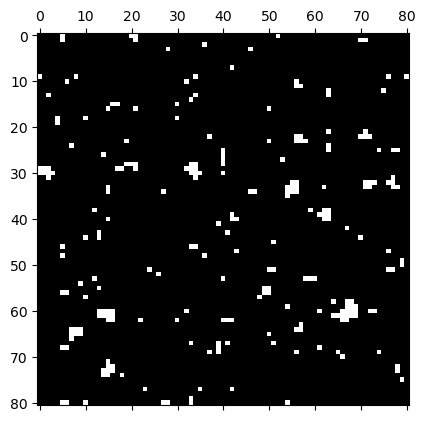

[====================] 100%

<Figure size 640x480 with 0 Axes>

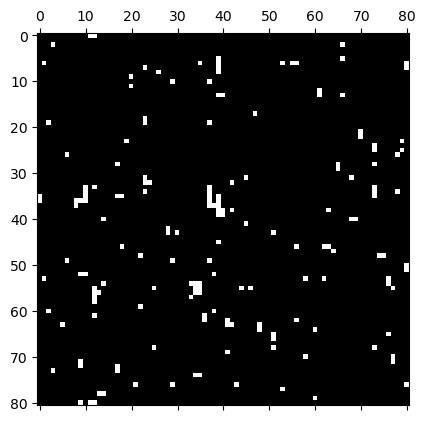

[====================] 100%

<Figure size 640x480 with 0 Axes>

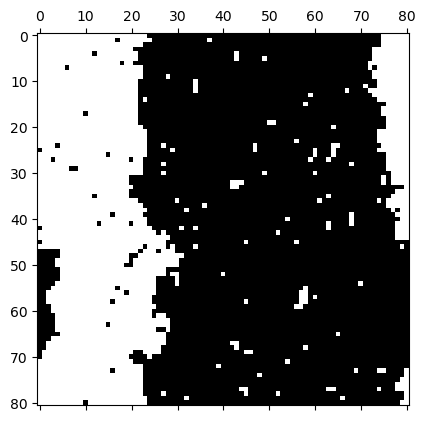

[====================] 100%

<Figure size 640x480 with 0 Axes>

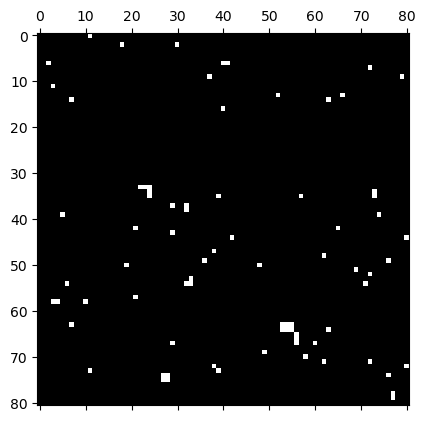

[====================] 100%

<Figure size 640x480 with 0 Axes>

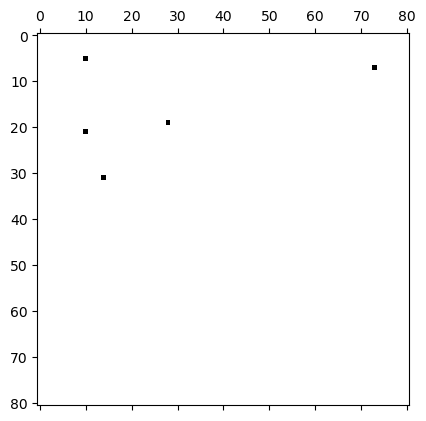

[====================] 100%

<Figure size 640x480 with 0 Axes>

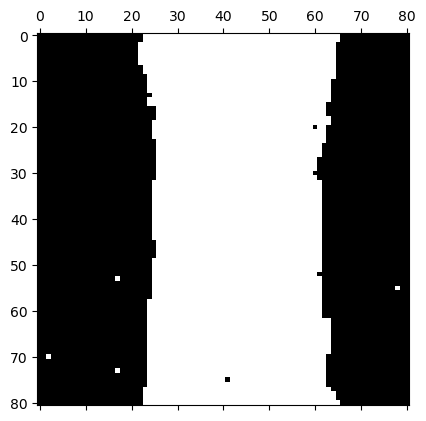

In [41]:
replace_Bs = [0.52, 0.54, 0.56, 0.6, 0.85, 1.0]
replace_M_coarse_avgs0, replace_M_coard_errors0 = M_Squared_vs_B(replace_Bs[0], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs1, replace_M_coard_errors1 = M_Squared_vs_B(replace_Bs[1], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs2, replace_M_coard_errors2 = M_Squared_vs_B(replace_Bs[2], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs3, replace_M_coard_errors3 = M_Squared_vs_B(replace_Bs[3], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs4, replace_M_coard_errors4 = M_Squared_vs_B(replace_Bs[4], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs5, replace_M_coard_errors5 = M_Squared_vs_B(replace_Bs[5], runs=15000, offset=5000, L=81, CG=1, print_grid=True)

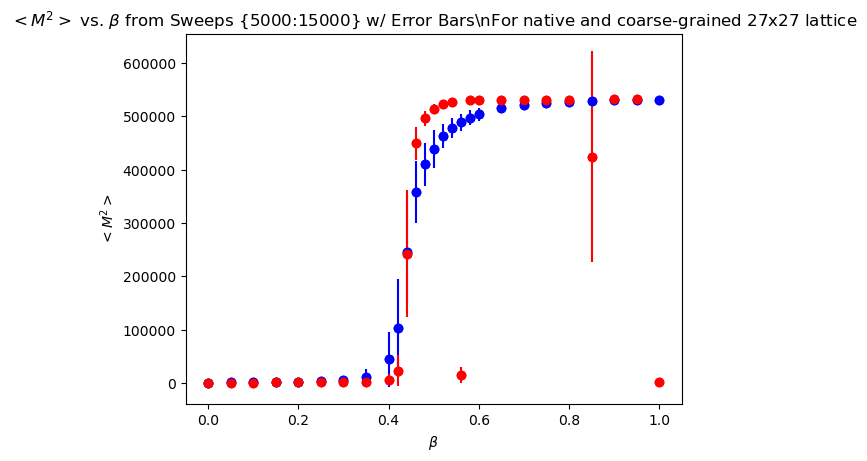

In [46]:
Bs = [0.0001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
replace_Bs = [0.52, 0.54, 0.56, 0.6, 0.85, 1.0]
replace_avgs = [replace_M_coarse_avgs0[0], replace_M_coarse_avgs1[0], replace_M_coarse_avgs2[0], replace_M_coarse_avgs3[0], replace_M_coarse_avgs4[0], replace_M_coarse_avgs5[0]]
replace_errors = [replace_M_coard_errors0[0], replace_M_coard_errors1[0], replace_M_coard_errors2[0], replace_M_coard_errors3[0], replace_M_coard_errors4[0], replace_M_coard_errors5[0]]
test_avgs, test_errors = [], []
replace_idx = 0
for i in range(len(Bs)):
    if Bs[i] in replace_Bs:
        test_avgs.append(replace_avgs[replace_idx])
        test_errors.append(replace_errors[replace_idx])
        replace_idx += 1
    else:
        test_avgs.append(M_coarse_avgs[i])
        test_errors.append(M_coarse_errors[i])
plt.figure()
plt.scatter(Bs, M_avgs, color='b', label='Native 27x27')
plt.errorbar(Bs, M_avgs, yerr=M_errors, fmt="o", color='b')
plt.scatter(Bs, test_avgs, color='r', label='Coarse-grained 27x27')
plt.errorbar(Bs, test_avgs, yerr=test_errors, fmt="o", color='r')
plt.title(r"$<M^2>$ vs. $\beta$ from Sweeps {5000:15000} w/ Error Bars\nFor native and coarse-grained 27x27 lattice")
plt.ylabel(r"$<M^2>$")
plt.xlabel(r"$\beta$")
plt.show()

[====================] 100%

<Figure size 640x480 with 0 Axes>

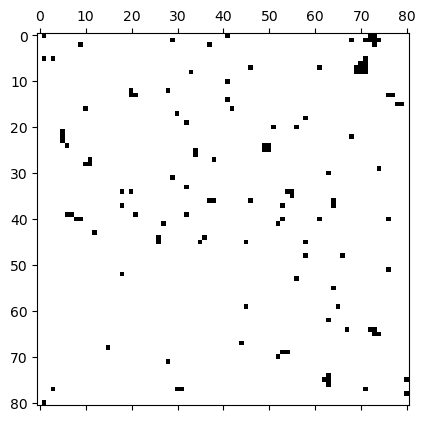

[====================] 100%

<Figure size 640x480 with 0 Axes>

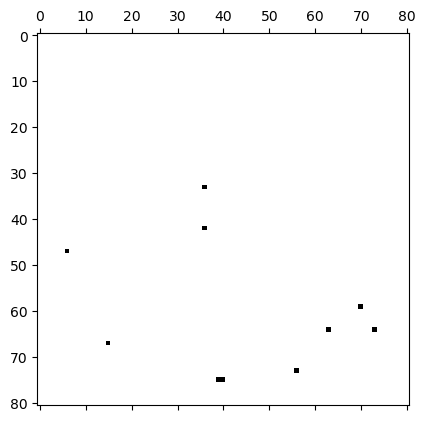

[====================] 100%

<Figure size 640x480 with 0 Axes>

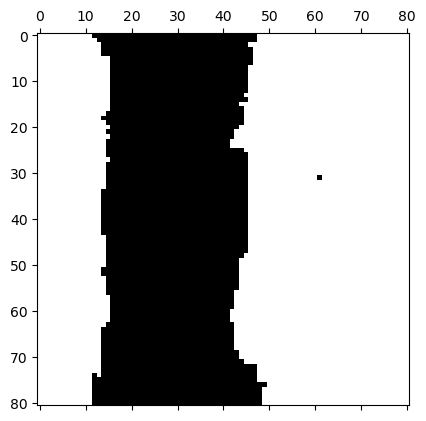

In [47]:
replace_Bs = [0.52, 0.54, 0.56, 0.6, 0.85, 1.0]
# replace_M_coarse_avgs0, replace_M_coard_errors0 = M_Squared_vs_B(replace_Bs[0], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
# replace_M_coarse_avgs1, replace_M_coard_errors1 = M_Squared_vs_B(replace_Bs[1], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs2, replace_M_coard_errors2 = M_Squared_vs_B(replace_Bs[2], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
# replace_M_coarse_avgs3, replace_M_coard_errors3 = M_Squared_vs_B(replace_Bs[3], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs4, replace_M_coard_errors4 = M_Squared_vs_B(replace_Bs[4], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs5, replace_M_coard_errors5 = M_Squared_vs_B(replace_Bs[5], runs=15000, offset=5000, L=81, CG=1, print_grid=True)

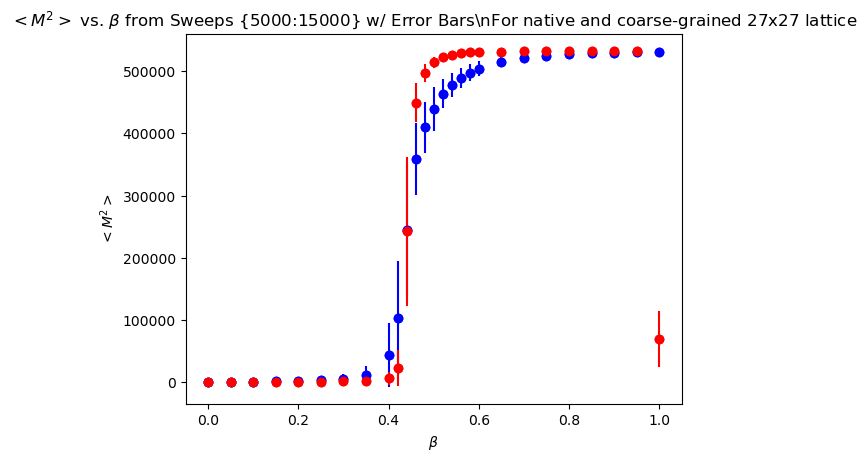

In [48]:
Bs = [0.0001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
replace_Bs = [0.52, 0.54, 0.56, 0.6, 0.85, 1.0]
replace_avgs = [replace_M_coarse_avgs0[0], replace_M_coarse_avgs1[0], replace_M_coarse_avgs2[0], replace_M_coarse_avgs3[0], replace_M_coarse_avgs4[0], replace_M_coarse_avgs5[0]]
replace_errors = [replace_M_coard_errors0[0], replace_M_coard_errors1[0], replace_M_coard_errors2[0], replace_M_coard_errors3[0], replace_M_coard_errors4[0], replace_M_coard_errors5[0]]
test_avgs, test_errors = [], []
replace_idx = 0
for i in range(len(Bs)):
    if Bs[i] in replace_Bs:
        test_avgs.append(replace_avgs[replace_idx])
        test_errors.append(replace_errors[replace_idx])
        replace_idx += 1
    else:
        test_avgs.append(M_coarse_avgs[i])
        test_errors.append(M_coarse_errors[i])
plt.figure()
plt.scatter(Bs, M_avgs, color='b', label='Native 27x27')
plt.errorbar(Bs, M_avgs, yerr=M_errors, fmt="o", color='b')
plt.scatter(Bs, test_avgs, color='r', label='Coarse-grained 27x27')
plt.errorbar(Bs, test_avgs, yerr=test_errors, fmt="o", color='r')
plt.title(r"$<M^2>$ vs. $\beta$ from Sweeps {5000:15000} w/ Error Bars\nFor native and coarse-grained 27x27 lattice")
plt.ylabel(r"$<M^2>$")
plt.xlabel(r"$\beta$")
plt.show()

[====================] 100%

<Figure size 640x480 with 0 Axes>

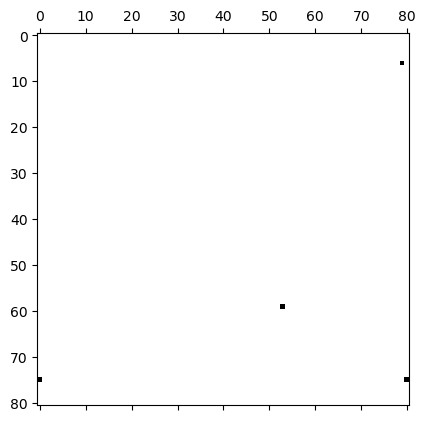

In [49]:
replace_Bs = [0.52, 0.54, 0.56, 0.6, 0.85, 1.0]
# replace_M_coarse_avgs0, replace_M_coard_errors0 = M_Squared_vs_B(replace_Bs[0], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
# replace_M_coarse_avgs1, replace_M_coard_errors1 = M_Squared_vs_B(replace_Bs[1], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
# replace_M_coarse_avgs2, replace_M_coard_errors2 = M_Squared_vs_B(replace_Bs[2], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
# replace_M_coarse_avgs3, replace_M_coard_errors3 = M_Squared_vs_B(replace_Bs[3], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
# replace_M_coarse_avgs4, replace_M_coard_errors4 = M_Squared_vs_B(replace_Bs[4], runs=15000, offset=5000, L=81, CG=1, print_grid=True)
replace_M_coarse_avgs5, replace_M_coard_errors5 = M_Squared_vs_B(replace_Bs[5], runs=15000, offset=5000, L=81, CG=1, print_grid=True)

In [51]:
Bs = [0.0001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
replace_Bs = [0.52, 0.54, 0.56, 0.6, 0.85, 1.0]
replace_avgs = [replace_M_coarse_avgs0[0], replace_M_coarse_avgs1[0], replace_M_coarse_avgs2[0], replace_M_coarse_avgs3[0], replace_M_coarse_avgs4[0], replace_M_coarse_avgs5[0]]
replace_errors = [replace_M_coard_errors0[0], replace_M_coard_errors1[0], replace_M_coard_errors2[0], replace_M_coard_errors3[0], replace_M_coard_errors4[0], replace_M_coard_errors5[0]]
test_avgs, test_errors = [], []
replace_idx = 0
for i in range(len(Bs)):
    if Bs[i] in replace_Bs:
        test_avgs.append(replace_avgs[replace_idx])
        test_errors.append(replace_errors[replace_idx])
        replace_idx += 1
    else:
        test_avgs.append(M_coarse_avgs[i])
        test_errors.append(M_coarse_errors[i])

In [46]:
# M_coarse_data_cleaned = [[B, Mca, Mce] for B, Mca, Mce in zip(Bs, test_avgs, test_errors)]
# with open("M_coarse_data_cleaned.pkl", "wb") as fp:   #Pickling
#     pickle.dump(M_coarse_data_cleaned, fp)

with open("M_coarse_data_cleaned.pkl", "rb") as fp:   # Unpickling
    M_coarse_data_cleaned = pickle.load(fp)

Bs = [o[0] for o in M_coarse_data_cleaned]
M_coarse_avgs_cleaned = [o[1] for o in M_coarse_data_cleaned]
M_coarse_errors_cleaned = [o[2] for o in M_coarse_data_cleaned]

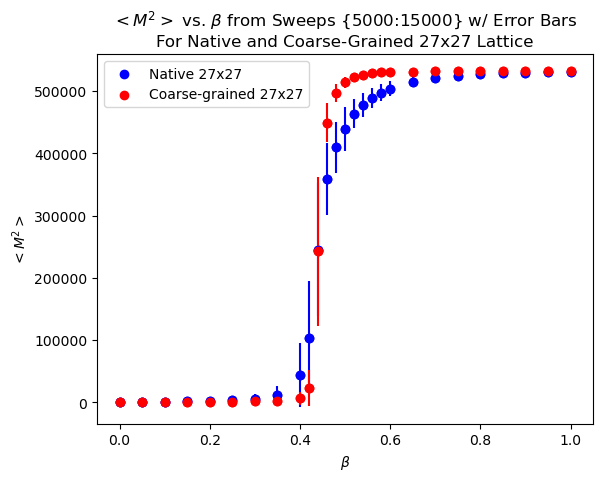

In [47]:
plt.figure()
plt.scatter(Bs, M_avgs, color='b', label='Native 27x27')
plt.errorbar(Bs, M_avgs, yerr=M_errors, fmt="o", color='b')
plt.scatter(Bs, M_coarse_avgs_cleaned, color='r', label='Coarse-grained 27x27')
plt.errorbar(Bs, M_coarse_avgs_cleaned, yerr=M_coarse_errors_cleaned, fmt="o", color='r')
plt.title(r"$<M^2>$ vs. $\beta$ from Sweeps {5000:15000} w/ Error Bars"+"\nFor Native and Coarse-Grained 27x27 Lattice")
plt.ylabel(r"$<M^2>$")
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

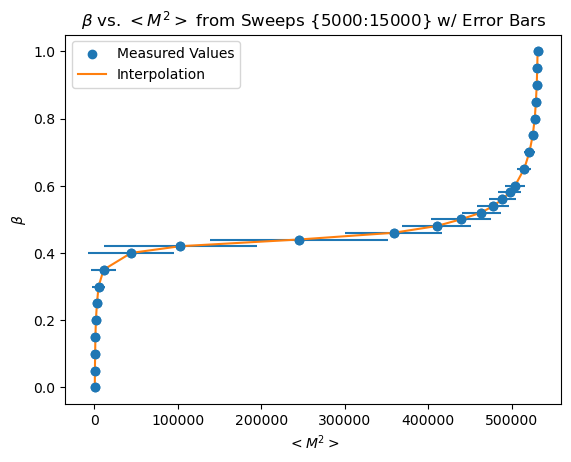

In [48]:
interp = interpolate.interp1d(M_avgs, Bs, fill_value='extrapolate')
plt.figure()
plt.scatter(M_avgs, Bs, label="Measured Values")
plt.errorbar(M_avgs, Bs, xerr=M_errors, fmt="o")
plt.plot(M_avgs, interp(M_avgs), label="Interpolation")
plt.title(r"$\beta$ vs. $<M^2>$ from Sweeps {5000:15000} w/ Error Bars")
plt.ylabel(r"$\beta$")
plt.xlabel(r"$<M^2>$")
plt.legend()
plt.show()

Transition Point is T = 2.271910047116237, B = 0.4401582717895509


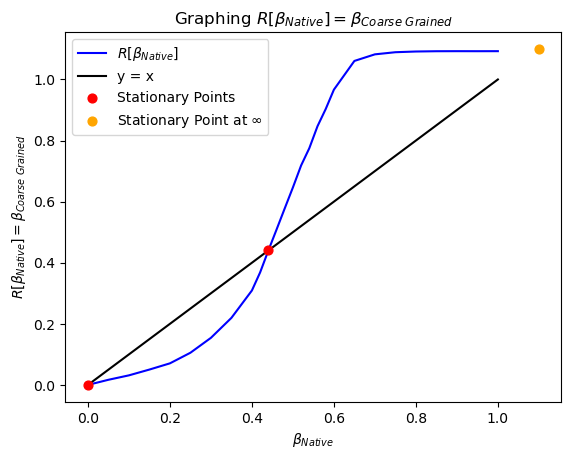

In [49]:
R = interpolate.interp1d(Bs, interp(M_coarse_avgs_cleaned), fill_value='extrapolate')
delta = 0.1
val=0.4
while delta > .0000001:
    if val > R(val):
        val += delta
        if val < R(val):
            delta = delta/2
    elif val < R(val):
        val += -delta
        if val > R(val):
            delta = delta/2
print(f"Transition Point is T = {1/val}, "+r"B"+f" = {val}")

plt.figure()
plt.plot(Bs, interp(M_coarse_avgs_cleaned), color='b', label=r'$R[\beta_{Native}]$')
plt.plot(Bs, Bs, color='black', label="y = x")
plt.scatter([0, val], [0, val], marker="o", label="Stationary Points", color='red', s=40, zorder=3)
plt.scatter([1.1], [1.1], marker="o", label=r"Stationary Point at $\infty$", color='orange', s=40, zorder=3)

plt.title(r"Graphing $R[\beta_{Native}] = \beta_{Coarse\ Grained}$")
plt.xlabel(r"$\beta_{Native}$")
plt.ylabel(r"$R[\beta_{Native}] = \beta_{Coarse\ Grained}$")
plt.legend()
plt.show()

In [50]:
def plot_arrows(start, num, label=''):
    point = start
    for i in range(num):
        L1 = min([abs(R(point)-point), 0.3])
        L2 = min([abs(R(R(point))-R(point)), 0.3])
        plt.arrow(point, R(point), R(point)-point, 0, head_width=L1/(3*4.5), length_includes_head=True)
        plt.arrow(R(point), R(point), 0, R(R(point))-R(point), head_width=L2/(3*4.5), length_includes_head=True)
        point = R(point)

Transition Point is T = 2.271910047116237, B = 0.4401582717895509
Slope at critical point = 3.5610403514851896
v = 0.8650131272163903


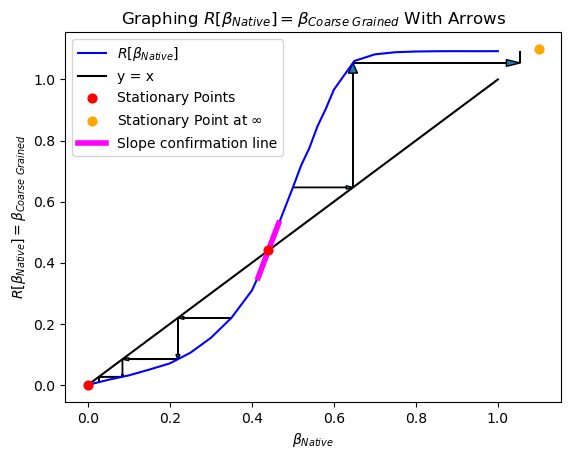

In [39]:
R = interpolate.interp1d(Bs, interp(M_coarse_avgs_cleaned), fill_value='extrapolate')
delta = 0.1
val=0.4
while delta > .0000001:
    if val > R(val):
        val += delta
        if val < R(val):
            delta = delta/2
    elif val < R(val):
        val += -delta
        if val > R(val):
            delta = delta/2
print(f"Transition Point is T = {1/val}, "+r"B"+f" = {val}")

plt.figure()
plt.plot(Bs, interp(M_coarse_avgs_cleaned), color='b', label=r'$R[\beta_{Native}]$')
plt.plot(Bs, Bs, color='black', label="y = x")
plt.scatter([0, val], [0, val], marker="o", label="Stationary Points", color='red', s=40, zorder=3)
plt.scatter([1.1], [1.1], marker="o", label=r"Stationary Point at $\infty$", color='orange', s=40, zorder=3)
plot_arrows(0.35, 3)
plot_arrows(0.5, 2)

plt.title(r"Graphing $R[\beta_{Native}] = \beta_{Coarse\ Grained}$ With Arrows")
plt.xlabel(r"$\beta_{Native}$")
plt.ylabel(r"$R[\beta_{Native}] = \beta_{Coarse\ Grained}$")



## Calculate v
delta = 0.00000000000001
point = val-0.01
slope = (R(point+delta)-R(point-delta))/(2*delta)
print(f"Slope at critical point = {slope}")
print(f"v = {1/m.log(slope, 3)}")
check_slope=True
if check_slope:
    b = (1-slope)*val
    lin_range = 0.025
    plt.plot(np.arange(val-lin_range, val+lin_range, 0.001), slope*np.arange(val-lin_range, val+lin_range, 0.001)+b,
             color='magenta', linewidth=4, label = 'Slope confirmation line')
plt.legend()
plt.show()

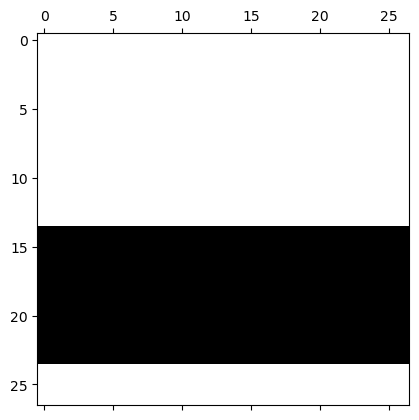

In [112]:
# model = Metropolis(27, 85, B=True)
# model.run(5000)
plt.matshow(model.get_grid_history()[-1], cmap='gray')

[====================] 100%

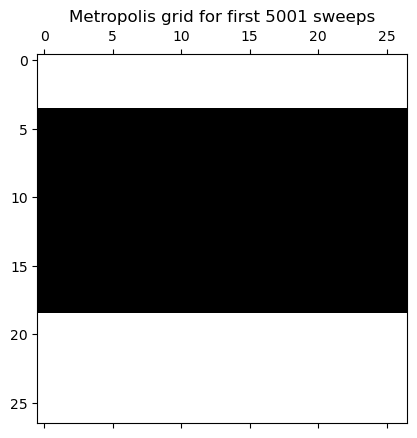

In [88]:
data = model.get_grid_history()
n_frames = len(data)

fig, ax = plt.subplots()
plot = ax.matshow(data[0], cmap="gray", animated=True)
plt.title(f"Metropolis grid for first {n_frames} sweeps")

def update(i):
    sys.stdout.write('\r')
    per = (i + 1) / n_frames
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*per), 100*per))
    sys.stdout.flush()
    plot.set_array(data[i])
    return [plot]

anim = FuncAnimation(fig, update, frames=n_frames, interval = 1, repeat=True, cache_frame_data=True)
anim.save("testing_metro_bug.gif")
plt.show()

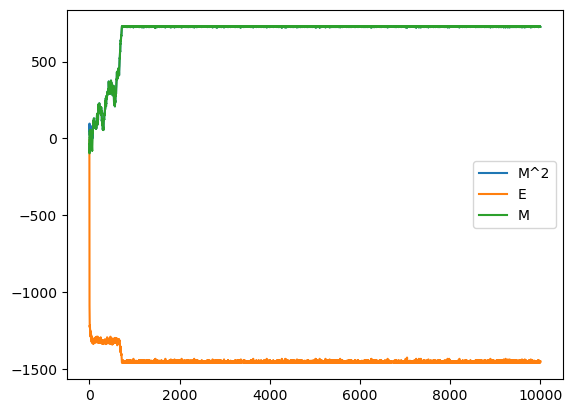

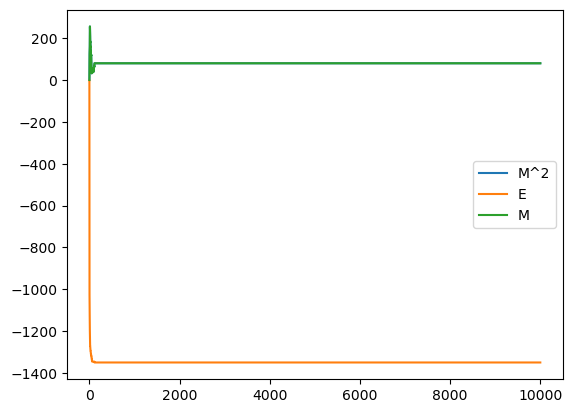

In [69]:
idx = 10
B = Betas[idx]
model = models[idx]
Es = model.get_energy_history()
Ms = [m.sqrt(M**2) for M in model.get_M_history()]
plt.figure()
plt.plot(Ms, label = "M^2")
plt.plot(Es, label="E")
plt.plot(model.get_M_history(), label="M")
plt.legend()
plt.show()

idx = 11
B = Betas[idx]
model = models[idx]
Es = model.get_energy_history()
Ms = [m.sqrt(M**2) for M in model.get_M_history()]
plt.figure()
plt.plot(Ms, label = "M^2")
plt.plot(Es, label="E")
plt.plot(model.get_M_history(), label="M")
plt.legend()
plt.show()

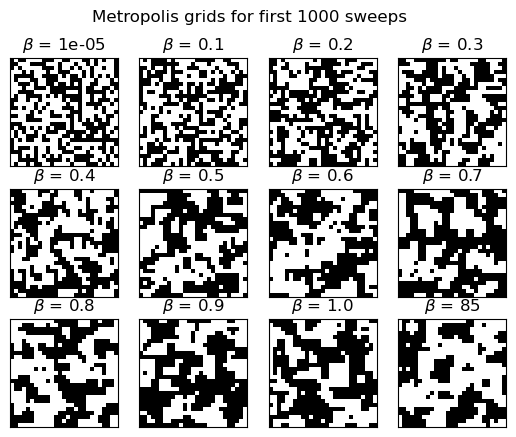

In [55]:
n_frames = len(data[0])
fig, axs = plt.subplots(3, 4)
fig.suptitle(f"Metropolis grids for first {n_frames} sweeps")
for i in range(3):
    for j in range(4):
        idx = i*4 + j
        axs[i, j].matshow(data[idx][0], cmap="gray", animated=True)
        axs[i, j].set_title(r"$\beta$"+ f" = {Betas[idx]}")
        axs[i, j].tick_params(top=False, labeltop=False, left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.show()

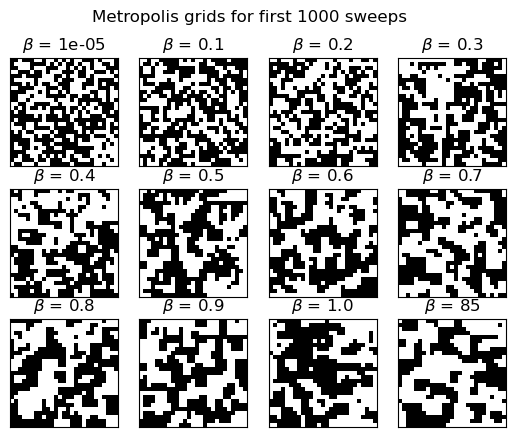

[====                ] 22%

KeyboardInterrupt: 

In [114]:
n_frames = len(data[0])
fig, axs = plt.subplots(3, 4)
fig.suptitle(f"Metropolis grids for first {n_frames} sweeps")
for i in range(3):
    for j in range(4):
        idx = i*4 + j
        axs[i, j].matshow(data[idx][0], cmap="gray", animated=True)
        axs[i, j].set_title(r"$\beta$"+ f" = {Betas[idx]}")
        axs[i, j].tick_params(top=False, labeltop=False, left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.show()

def update(frame):
    sys.stdout.write('\r')
    per = (frame + 1) / n_frames
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*per), 100*per))
    sys.stdout.flush()
    for i in range(3):
        for j in range(4):
            axs[i, j].matshow(data[i*4 + j][frame], cmap="gray", animated=True)
    return [fig]

anim = FuncAnimation(fig, update, frames=n_frames, interval = 1, repeat=True, cache_frame_data=False)
anim.save(f"metropolis_all.gif")
plt.show()

In [111]:
Bs = []
E_avgs = []
M2_avgs = []
for B in np.arange(0, 1.05, 0.05):
    B = round(B, 5)
    if B == 0: B = 0.00001
    print(f"Processing with B={B}")
    Bs.append(B)
    test_metro = Metropolis(27, B, B=True)
    test_metro.run(7000)
    energies = test_metro.get_energy_history()
    E_avg = sum(energies[3500:])/len(energies[3500:])
    E_avgs.append(E_avg)
    M2 = [M**2 for M in test_metro.get_M_history()]
    M2_avg = sum(M2[1000:])/len(M2[1000:])
    M2_avgs.append(M2_avg)

Processing with B=1e-05
Processing with B=0.05
Processing with B=0.1
Processing with B=0.15
Processing with B=0.2
Processing with B=0.25
Processing with B=0.3
Processing with B=0.35
Processing with B=0.4
Processing with B=0.45
Processing with B=0.5
Processing with B=0.55
Processing with B=0.6
Processing with B=0.65
Processing with B=0.7
Processing with B=0.75
Processing with B=0.8
Processing with B=0.85
Processing with B=0.9
Processing with B=0.95
Processing with B=1.0


In [10]:
import pickle
# observables = [[B, E, M] for B, E, M in zip(Bs, E_avgs, M2_avgs)]
# with open("observables.pkl", "wb") as fp:   #Pickling
#     pickle.dump(observables, fp)

with open("observables.pkl", "rb") as fp:   # Unpickling
    observables = pickle.load(fp)

Bs = [o[0] for o in observables]
E_avgs = [o[1] for o in observables]
M2_avgs = [o[2] for o in observables]

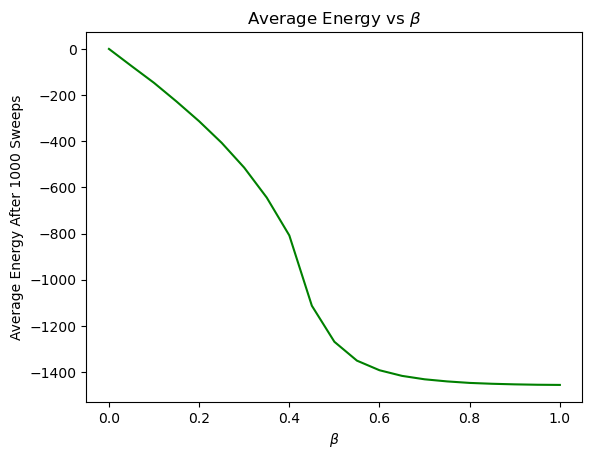

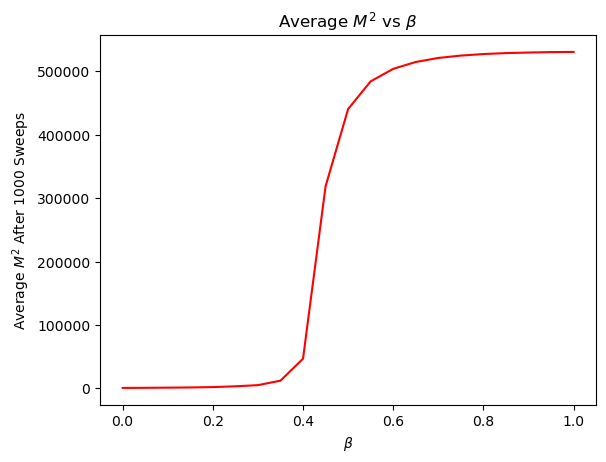

In [11]:
plt.figure()
plt.plot(Bs, E_avgs, color='g')
plt.title(r"Average Energy vs $\beta$")
plt.xlabel(r"$\beta$")
plt.ylabel("Average Energy After 1000 Sweeps")

plt.figure()
plt.plot(Bs, M2_avgs, color='r')
plt.title(r"Average $M^2$ vs $\beta$")
plt.xlabel(r"$\beta$")
plt.ylabel(r"Average $M^2$ After 1000 Sweeps")
plt.show()